In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
np.set_printoptions(threshold=1e3, suppress=True, precision=2)

In [10]:
class Dataset:
    def __init__(self):
        self.X = None
        self.X_t = None
        self.y_hat = None
        self.df = None
        self.w = None
    def normalize(self):
        mean_x = np.nanmean(self.X, axis=1)
        std_x = np.nanstd(self.X, axis=1)
        std_x[std_x == 0] = 1
        self.X = (self.X - mean_x[:, np.newaxis]) / std_x[:, np.newaxis]
        self.X_t = self.X.T

trainset = Dataset()
trainset.df = pd.read_csv('train_datas_0.csv', dtype='float', na_values='-')
trainset.df1 = pd.read_csv('train_datas_1.csv').apply(pd.to_numeric, errors='coerce')

testset = Dataset()
testset.df = pd.read_csv('test_datas.csv', dtype='float', na_values='-')

In [93]:
def preprocess_training_data(sel_cols=['PM2.5']):
    # correct dataframe
    trainset.df1.drop(trainset.df1.index[-2+2162:-2+2208], inplace=True)
    trainset.df1.dropna(how='all', inplace=True)
    trainset.df1.drop(trainset.df1.index[(trainset.df1 == 0).all(axis=1)], inplace=True)
    for s in (trainset.df, trainset.df1, testset.df):
        for cnam in s.columns:
            # fill NaN with mean
            s[cnam].fillna(s[cnam].mean(), inplace=True)

            # replace outlier with mean
            # TODO: inplace?
            s[cnam][abs(s[cnam] - s[cnam].mean()) > 10 * s[cnam].std()] = s[cnam].mean()

        s.reindex()

    # extract feature
    c = len(sel_cols)
    d = c * 9 * 2 + 18
    n = len(trainset.df) - 9 + len(trainset.df1) - 9
    X = torch.zeros((n, d))
    y_hat = torch.zeros((n, 1))
    
    for i in range(len(trainset.df)-9):
        X[i, 0:c*9] = torch.tensor(trainset.df.iloc[i:i+9][sel_cols].values.flatten())
        #X[i, c*9:c*9*2] = X[i, 0:c*9] ** 2
        for j in range(9):
            X[i, c*9*2+j] = (i+j) % 24 # hour
        for j in range(9):
            X[i, c*9*2+9+j] = ((i+j) // 24) % 365 # day
        y_hat[i] = trainset.df.iloc[i+9]['PM2.5']
    
#     off = len(trainset.df) - 9
#     for i in range(len(trainset.df1)-9):
#         X[i+off, 0:15*9] = torch.tensor(trainset.df1.iloc[i:i+9].values.flatten())
#         X[i+off, 15*9] = i % 24 # hour
#         X[i+off, 15*9+1] = (i // 24) % 365 # day
#         y_hat[i] = trainset.df1.iloc[i+9]['PM2.5']

    trainset.X = X
    trainset.y_hat = y_hat
    #trainset.normalize()

preprocess_training_data()

(array([ 764., 1930., 1824., 1486.,  926.,  706.,  443.,  328.,  147.,
         104.,   48.,   14.,   15.,    9.,    8.,    3.,    4.,    0.,
           0.,    3.]),
 array([  2.  ,   9.55,  17.1 ,  24.65,  32.2 ,  39.75,  47.3 ,  54.85,
         62.4 ,  69.95,  77.5 ,  85.05,  92.6 , 100.15, 107.7 , 115.25,
        122.8 , 130.35, 137.9 , 145.45, 153.  ]),
 <BarContainer object of 20 artists>)

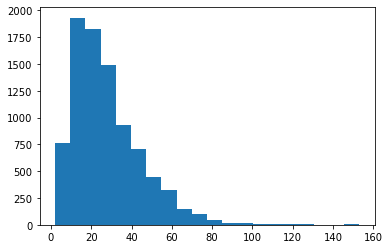

In [94]:
plt.hist(trainset.df['PM2.5'],bins=20)

In [103]:
def train(X, y_hat):
    n, d = X.shape

    linear_module = nn.Linear(d, 1, bias=True)
    loss_func = nn.MSELoss()
    optim = torch.optim.Adam(linear_module.parameters(), lr=1e-1, betas=(0.99, 0.999))
    num_iter = 2000

    print('iter,\tloss,\tw')

    for i in range(num_iter):
        y = linear_module(X)
        loss = loss_func(y, y_hat)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if i == num_iter - 1:
            print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(d).detach().numpy()))

    print('\ntrue w\t\t', )#true_w.view(2).numpy())
    print('estimated w\t', linear_module.weight.view(d).detach().numpy())
    print('bias\t', linear_module.bias.view(1).detach().numpy())
    
    testset.linear_module = linear_module

train(trainset.X, trainset.y_hat)

iter,	loss,	w
1999,	18.95,	[ 0.    0.03  0.05 -0.02  0.02  0.    0.01  0.15  0.72 -0.08  0.15  0.09
 -0.16 -0.15 -0.14  0.04 -0.1  -0.    0.07  0.01 -0.02 -0.02 -0.02  0.02
 -0.03  0.03  0.04 -0.05  0.07 -0.09  0.07  0.03  0.05 -0.12  0.09 -0.06]

true w		
estimated w	 [ 0.    0.03  0.05 -0.02  0.02  0.    0.01  0.15  0.72 -0.08  0.15  0.09
 -0.16 -0.15 -0.14  0.04 -0.1  -0.    0.07  0.01 -0.02 -0.02 -0.02  0.02
 -0.03  0.03  0.04 -0.05  0.07 -0.09  0.07  0.03  0.05 -0.12  0.09 -0.06]
bias	 [0.08]


In [96]:
def validate():
    X = trainset.X
    y_hat = trainset.y_hat
    n, d = X.shape

    validate_sz = 2000
    losses = []
    loss_func = nn.MSELoss()
    for i in range(0, n, validate_sz):
        idx_validate = pd.Series([False] * n)
        idx_validate[i:i+validate_sz] = True

        train(X[~idx_validate], y_hat[~idx_validate])
        y = testset.linear_module(X[idx_validate])
        l = loss_func(y, y_hat[idx_validate])
        losses.append(l)

    print('validate loss', np.mean(losses))
    print()

#validate()

In [97]:
def preprocess_testing_data(sel_cols=['PM2.5']):
    c = len(sel_cols)
    d = c * 9 * 2 + 18
    n = (len(testset.df) + 8) // 9
    X = torch.zeros((n, d))

    # extract feature
    for i in range(n):
        X[i, 0:c*9] = torch.tensor(testset.df.iloc[i*9:(i+1)*9][sel_cols].values.flatten())
        #X[i, c*9:c*9*2] = X[i, 0:c*9] ** 2
        for j in range(9):
            X[i, c*9*2+j] = (i*9+j) % 24 # hour
        for j in range(9):
            X[i, c*9*2+9+j] = ((i*9+j) // 24) % 365 # day
    testset.X = X

    #testset.normalize()

preprocess_testing_data()

In [98]:
def test():
    X = testset.X
    linear_module = testset.linear_module
    n, d = X.shape
    
    y = linear_module(X)
    y = torch.round(y).view(n).detach().numpy()
    print(y)
    testset.y = y

test()

[13. 18. 20. 36. 25. 42. 55. 66. 68. 57. 43. 36. 58. 49. 40. 47. 32. 30.
 21. 32. 32. 34. 27. 21. 24. 15.  7.  9. 22. 20. 22. 19. 16. 17. 23. 27.
 17. 21.  9.  7. 10. 23. 19. 24. 21. 28. 29. 34. 33. 29. 47. 31. 37. 39.
 22. 27. 11. 14.  6.  4.  5.  2.  5.  9.  9.  7.  3.  8. 21. 21. 26. 31.
 23. 23. 53. 24. 19. 14. 17. 17. 19. 14.  5. 12. 21. 21. 12.  9.  8. 11.
 13. 12. 14. 20. 26. 26. 39. 34. 30. 24. 49. 33. 24. 11.  1. 29. 27. 17.
 16.  7.  3. 11. 15. 16. 13. 19. 23. 23. 23. 16. 17. 24. 24. 30. 23. 28.
 22. 24. 39. 52. 37. 11. 14. 10. 24. 19. 16. 19. 29. 19. 28. 30. 26. 11.
 11. 15. 21. 24. 27. 16.  3.  7.  8. 22. 22. 25. 10. 15. 25. 22. 23. 19.
 12. 10.  8. 14. 27. 32. 29. 27. 37. 18.  4. 15. 15. 20. 22. 19. 28. 27.
 22. 28. 25. 39. 28. 26. 20. 26. 32. 35. 23. 25. 22. 17. 21. 24. 21. 26.
 23. 25. 31. 25. 22. 22. 18. 13. 10.  5.  3. 17. 15. 16. 15. 18. 19. 25.
 15. 17. 19. 25. 24. 28. 22. 16. 19. 21. 24. 15.  3. 20. 14. 18. 26. 23.
 23. 19. 29. 38. 25. 29. 32. 17.  8. 14. 16. 27. 32

(array([101., 152.,  87.,  83.,  44.,  18.,   6.,   4.,   3.,   2.]),
 array([ 1. ,  7.7, 14.4, 21.1, 27.8, 34.5, 41.2, 47.9, 54.6, 61.3, 68. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

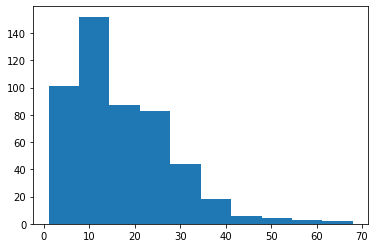

In [99]:
plt.hist(testset.y)

In [100]:
pred_df = pd.DataFrame({
    'id': ['id_' + str(i) for i in range(500)],
    'value': testset.y
})
pred_df.to_csv('submission.csv', index=False)

In [40]:
def closed_form_solution():
    w_hat, residuals, rank, s  = np.linalg.lstsq(trainset.X_t, trainset.y_hat)
    X = trainset.X
    X_t = trainset.X_t
    y_hat = trainset.y_hat
    assert w_hat.shape[0] == DIM
    print('w_hat',w_hat)
    print('train loss', np.linalg.norm(trainset.X_t.dot(w_hat) - trainset.y_hat)**2)
    testset.w = w_hat

    loss = []
    d, n = trainset.X.shape
    validate_sz = 2000
    for i in range(0, n, validate_sz):
        idx_validate = pd.Series([False] * n)
        idx_validate[i:i+validate_sz] = True
        loss.append(validate(X[:, idx_validate], y_hat[idx_validate], testset.w))
    print('validation loss', np.mean(loss))
    
    return np.dot(testset.X_t, w_hat).round(0).astype(int)

# y_pred = closed_form_solution()